# Training hybrid models using the Pennylane backend

In this example, we will first train a pure quantum model using PennyLane and PyTorch to classify whether a sentence is about cooking or computing. We will then train a hybrid model that takes in pairs of sentences and determines whether they are talking about the same or different topics.

In [1]:
BATCH_SIZE = 10
EPOCHS = 30
LEARNING_RATE = 0.1
SEED = 2

In [2]:
import torch
import random
import numpy as np

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

### Read in the data and create diagrams

In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mc_test_data.txt')

In [ ]:
import os

TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))

if TESTING:
    train_labels, train_data = train_labels[:3], train_data[:3]
    dev_labels, dev_data = dev_labels[:3], dev_data[:3]
    test_labels, test_data = test_labels[:3], test_data[:3]
    EPOCHS = 1

In [4]:
from lambeq import BobcatParser

reader = BobcatParser(verbose='text')

raw_train_diagrams = reader.sentences2diagrams(train_data)
raw_dev_diagrams = reader.sentences2diagrams(dev_data)
raw_test_diagrams = reader.sentences2diagrams(test_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


### Remove cups

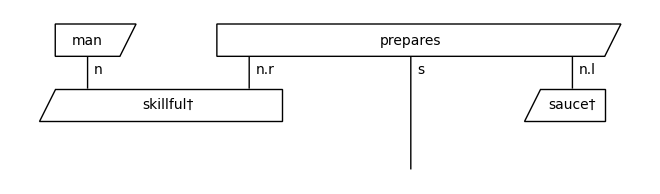

In [5]:
from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[0].draw()

### Create circuits

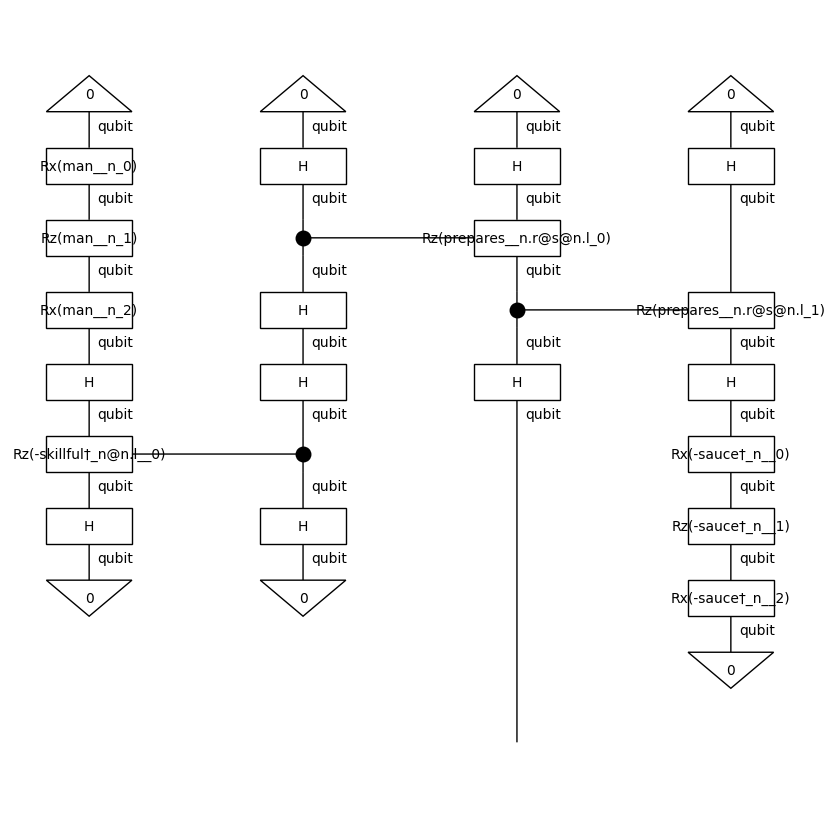

In [6]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(8, 8))

### Create (pure quantum) model and initialise parameters

In [7]:
from lambeq import PennyLaneModel

all_circuits = train_circuits + dev_circuits + test_circuits

model = PennyLaneModel.from_diagrams(all_circuits)
model.initialise_weights()

### Prepare train dataset

In [8]:
from lambeq import Dataset

train_dataset = Dataset(train_circuits,
                        train_labels,
                        batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels)

### Training

##### Using `PytorchTrainer`

In [9]:
def acc(y_hat, y):
    return (torch.argmax(y_hat, dim=1) == 
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.mse_loss(y_hat, y)

In [10]:
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
        model=model,
        loss_function=loss,
        optimizer=torch.optim.Adam,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions={"acc": acc},
        evaluate_on_train=True,
        use_tensorboard=False,
        verbose='text',
        seed=SEED
    )

trainer.fit(train_dataset, val_dataset)

Epoch 1:   train/loss: 0.1542   valid/loss: 0.2271   train/time: 0.88s   valid/time: 0.23s   train/acc: 0.5571   valid/acc: 0.5333
Epoch 2:   train/loss: 0.1318   valid/loss: 0.2877   train/time: 0.59s   valid/time: 0.17s   train/acc: 0.8571   valid/acc: 0.6000
Epoch 3:   train/loss: 0.0677   valid/loss: 0.1879   train/time: 0.53s   valid/time: 0.16s   train/acc: 0.8429   valid/acc: 0.7333
Epoch 4:   train/loss: 0.1274   valid/loss: 0.1289   train/time: 0.62s   valid/time: 0.17s   train/acc: 0.9000   valid/acc: 0.8333
Epoch 5:   train/loss: 0.0604   valid/loss: 0.1909   train/time: 0.48s   valid/time: 0.16s   train/acc: 0.8571   valid/acc: 0.6667
Epoch 6:   train/loss: 0.0572   valid/loss: 0.1599   train/time: 0.48s   valid/time: 0.16s   train/acc: 0.8857   valid/acc: 0.7333
Epoch 7:   train/loss: 0.0147   valid/loss: 0.1156   train/time: 0.58s   valid/time: 0.47s   train/acc: 0.9286   valid/acc: 0.8000
Epoch 8:   train/loss: 0.0057   valid/loss: 0.0661   train/time: 0.76s   valid/time

##### Determine test accuracy

In [11]:
def accuracy(circs, labels):
    probs = model(circs)
    return (torch.argmax(probs, dim=1) == 
            torch.argmax(torch.tensor(labels), dim=1)).sum().item()/len(circs)

accuracy(test_circuits, test_labels)

1.0

##### Using standard PyTorch

As we have a small dataset, we can use early stopping to prevent overfitting to the training data.

In [12]:
def accuracy(circs, labels):
    probs = model(circs)
    return (torch.argmax(probs, dim=1) == 
            torch.argmax(torch.tensor(labels), dim=1)).sum().item()/len(circs)

In [13]:
import pickle

model = PennyLaneModel.from_diagrams(all_circuits)
model.initialise_weights()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

best = {'acc': 0, 'epoch': 0}

for i in range(EPOCHS):
    epoch_loss = 0
    for circuits, labels in train_dataset:
        optimizer.zero_grad()
        probs = model(circuits)
        d_type = model.weights[0].dtype
        probs = probs.to(d_type)
        loss = torch.nn.functional.mse_loss(probs, 
                                            torch.tensor(labels))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    if i % 5 == 0:
        dev_acc = accuracy(dev_circuits, dev_labels)
        
        print("Epoch: {}".format(i))
        print("Train loss: {}".format(epoch_loss))
        print("Dev acc: {}".format(dev_acc))
        
        if dev_acc > best['acc']:
            best['acc'] = dev_acc
            best['epoch'] = i
            model.save("model.lt")
        elif i - best['epoch'] >= 10:
            print("Early stopping")
            break
    
if best["acc"] > accuracy(dev_circuits, dev_labels):   
    model.load("model.lt")

Epoch: 0
Train loss: 1.8844525068998337
Dev acc: 0.8
Epoch: 5
Train loss: 0.19278147350996733
Dev acc: 0.9666666666666667
Epoch: 10
Train loss: 0.014470159949269146
Dev acc: 0.9333333333333333
Epoch: 15
Train loss: 0.000635529821011005
Dev acc: 0.9666666666666667
Early stopping


### Determine the test accuracy

In [14]:
accuracy(test_circuits, test_labels)

0.9666666666666667

### Creating a hybrid model

This model will take in pairs of diagrams and attempt to determine whether they are talking about the same or different topics. It does this by first running the circuits to get a probability ouput on the open wire, and then passes this output to a simple neural network. We expect the circuits to learn to output [0, 1] or [1, 0] depending on the topic they are referring to (cooking or computing), and the neural network to learn to XOR these outputs to determine whether the topics are the same (in which case it should ouput 0) or different (in which case it should output 1). PennyLane allows us to train both the circuits and the NN simultaneously using PyTorch autograd.

In [15]:
BATCH_SIZE = 50
EPOCHS = 100
LEARNING_RATE = 0.1
SEED = 2

In [16]:
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

As the probability outputs from our circuits are guaranteed to be positive, we transform these outputs `x` by `2 * (x - 0.5)`, giving inputs to the neural network in the range [-1, 1]. This helps us to avoid "dying ReLUs", which could otherwise occur if all the input weights to a given neuron were negative, leading to the gradient of all these weights being 0. (A couple of alternative approaches could also involve initialising all the neural network weights to be positive, or using `LeakyReLU` as the activation function).

In [17]:
from torch import nn

class XORSentenceModel(PennyLaneModel):
    def __init__(self, **kwargs):
        PennyLaneModel.__init__(self, **kwargs)
        
        self.xor_net = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
            )
        
    def forward(self, diagram_pairs):
        a, b = zip(*diagram_pairs)
        evaluated_pairs = torch.cat((self.get_diagram_output(a),
                                     self.get_diagram_output(b)),
                                    dim=1)
        evaluated_pairs = 2 * (evaluated_pairs - 0.5)
        out = self.xor_net(evaluated_pairs)
        return out

### Make paired dataset

In [18]:
from itertools import combinations

def make_pair_data(diagrams, labels):
    pair_diags = list(combinations(diagrams, 2))
    pair_labels = [int(x[0] == y[0]) for x, y in combinations(labels, 2)]
    
    return pair_diags, pair_labels

train_pair_circuits, train_pair_labels = make_pair_data(train_circuits, 
                                                        train_labels)
dev_pair_circuits, dev_pair_labels = make_pair_data(dev_circuits, dev_labels)
test_pair_circuits, test_pair_labels = make_pair_data(test_circuits, 
                                                      test_labels)

There are lots of pairs (2415 train pairs), so we'll sample a subset to make this example train more quickly.

In [19]:
TRAIN_SAMPLES, DEV_SAMPLES, TEST_SAMPLES = 300, 200, 200

In [ ]:
if TESTING:
    TRAIN_SAMPLES, DEV_SAMPLES, TEST_SAMPLES = 2, 2, 2

In [20]:
train_pair_circuits, train_pair_labels = (
    zip(*random.sample(list(zip(train_pair_circuits, train_pair_labels)),
                       TRAIN_SAMPLES)))
dev_pair_circuits, dev_pair_labels = (
    zip(*random.sample(list(zip(dev_pair_circuits, dev_pair_labels)), DEV_SAMPLES)))
test_pair_circuits, test_pair_labels = (
    zip(*random.sample(list(zip(test_pair_circuits, test_pair_labels)), TEST_SAMPLES)))

### Initialise the model

In [21]:
all_pair_circuits = (train_pair_circuits +
                     dev_pair_circuits +
                     test_pair_circuits)
a, b = zip(*all_pair_circuits)

model = XORSentenceModel.from_diagrams(a + b)
model.initialise_weights()

train_pair_dataset = Dataset(train_pair_circuits,
                             train_pair_labels,
                             batch_size=BATCH_SIZE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Train the model and log accuracies

Only log every five epochs as evaluating is expensive.

In [22]:
def accuracy(circs, labels):
    predicted = model(circs)
    return (torch.round(torch.flatten(predicted)) == 
            torch.Tensor(labels)).sum().item()/len(circs)

In [23]:
best = {'acc': 0, 'epoch': 0}

for i in range(EPOCHS):
    epoch_loss = 0
    for circuits, labels in train_pair_dataset:
        optimizer.zero_grad()
        predicted = model(circuits)
        loss = torch.nn.functional.binary_cross_entropy(
            torch.flatten(predicted), torch.Tensor(labels))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    if i % 5 == 0:
        dev_acc = accuracy(dev_pair_circuits, dev_pair_labels)

        print("Epoch: {}".format(i))
        print("Train loss: {}".format(epoch_loss))
        print("Dev acc: {}".format(dev_acc))

        if dev_acc > best['acc']:
            best['acc'] = dev_acc
            best['epoch'] = i
            model.save("xor_model.lt")
        elif i - best['epoch'] >= 10:
            print("Early stopping")
            break
        
if best["acc"] > accuracy(dev_pair_circuits, dev_pair_labels):   
    model.load("xor_model.lt")
    model = model.double()

Epoch: 0
Train loss: 4.250532507896423
Dev acc: 0.53
Epoch: 5
Train loss: 1.186747632920742
Dev acc: 0.825
Epoch: 10
Train loss: 0.35468656790908426
Dev acc: 0.545
Epoch: 15
Train loss: 0.41043267399072647
Dev acc: 0.875
Epoch: 20
Train loss: 0.0038383470964618027
Dev acc: 0.88
Epoch: 25
Train loss: 0.0011570464266696945
Dev acc: 0.88
Epoch: 30
Train loss: 0.0007703642331762239
Dev acc: 0.88
Early stopping


In [24]:
accuracy(test_pair_circuits, test_pair_labels)

0.89